In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier

In [6]:
# reading dataset using panda
data_path = "../data/data_income.csv"
data_df = pd.read_csv(data_path)

In [7]:
data_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [8]:
# Define the features and target
X = data_df.drop(["income"], axis=1)
y = data_df["income"]

# Define the categorical columns to one-hot encode
categorical_cols = [
    "occupation",
    "education",
    "workclass",
    "marital-status",
    "relationship",
    "race",
    "native-country",
    "gender",
]
numeric_cols = [
    "age",
    "fnlwgt",
    "educational-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
# fix the format for y
y_train = y_train.replace({">50K": 1, "<=50K": 0})
y_test = y_test.replace({">50K": 1, "<=50K": 0})


In [10]:
# Define preprocessing for categorical and numeric data
categorical_preprocessor = OneHotEncoder()
numeric_preprocessor = StandardScaler()

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_preprocessor, categorical_cols),
        ("num", numeric_preprocessor, numeric_cols),
    ],
    remainder="passthrough",  # You can use this to include any remaining columns
)

# Create a pipeline with preprocessing and the machine learning model
model = XGBClassifier(random_state=42)

pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])
# Fit the pipeline (including preprocessing) to the training data
pipeline.fit(X_train, y_train)
# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: Fut

Accuracy: 0.8750


/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: Fut

Plot de l'accuracy par genre et couleur de peau

In [11]:
from sklearn.metrics import accuracy_score

# Calculer l'accuracy par genre
accuracy_par_genre = {}
genres = ['Male', 'Female']
for genre in genres:
    mask_genre = X_test['gender'] == genre
    accuracy_genre = accuracy_score(y_test[mask_genre], y_pred[mask_genre])
    accuracy_par_genre[genre] = accuracy_genre

# Calculer l'accuracy par race
accuracy_par_race = {}
races = ['White', 'Black']
for race in races:
    mask_race = X_test['race'] == race
    accuracy_race = accuracy_score(y_test[mask_race], y_pred[mask_race])
    accuracy_par_race[race] = accuracy_race

# Créer un tableau double entrée avec les accuracies
tableau_accuracies = pd.DataFrame({
    'Global': accuracy,
    'Male': accuracy_par_genre['Male'],
    'Female': accuracy_par_genre['Female'],
    'White': accuracy_par_race['White'],
    'Black': accuracy_par_race['Black']
}, index=['Accuracy'])

print(tableau_accuracies)

            Global     Male    Female     White     Black
Accuracy  0.875013  0.84196  0.941068  0.867037  0.930187


/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: Fut

Statistical Parity Test Homme / Femme

In [12]:
# fix the format for y
data_df['income'] = data_df['income'].replace({">50K": 1, "<=50K": 0})

In [13]:
# Diviser le DataFrame en deux groupes en fonction du genre
group1 = data_df[data_df['gender'] == 'Male']
group2 = data_df[data_df['gender'] == 'Female']

In [14]:
# Parité statistique : Comparer les proportions de prédictions positives entre les groupes
prop_group1_positive = group1['income'].mean()
prop_group2_positive = group2['income'].mean()

# Afficher les résultats
print(f"Parité statistique - Proportion de prédictions positives pour homme : {prop_group1_positive}")
print(f"Parité statistique - Proportion de prédictions positives pour femme : {prop_group2_positive}")

Parité statistique - Proportion de prédictions positives pour homme : 0.3037672281776417
Parité statistique - Proportion de prédictions positives pour femme : 0.10925148221343874


In [15]:
from scipy.stats import chi2_contingency

# Données d'exemple (à remplacer par vos propres données)
group1_predictions = pipeline.predict(group1.drop(["income"], axis=1))
group2_predictions = pipeline.predict(group2.drop(["income"], axis=1))

print(group1_predictions)
print(group2_predictions)

# Ajuster la taille des groupes
min_length = min(len(group1_predictions), len(group2_predictions))
group1_predictions = group1_predictions[:min_length]
group2_predictions = np.random.choice(group2_predictions, min_length, replace=False)

# Convertir les données en float64
group1_predictions = group1_predictions.astype(np.float64)
group2_predictions = group2_predictions.astype(np.float64)

# Ajouter une petite constante aux données pour éviter les fréquences nulles
epsilon = 1e-10
group1_predictions += epsilon
group2_predictions += epsilon

# Créer un tableau de contingence
contingency_table = np.array([group1_predictions, group2_predictions])

# Effectuer le test du chi-carré
chi2, p, _, _ = chi2_contingency(contingency_table, correction=True)

# Interpréter le résultat
print(f"chi2 = {chi2}")
if p < 0.05:
    print("La parité statistique n'est pas respectée.")
else:
    print("Pas de preuve significative de violation de la parité statistique.")

/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: Fut

[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 1]
chi2 = 4581.966582082703
Pas de preuve significative de violation de la parité statistique.


In [20]:
data_df["prediction"] = pipeline.predict(data_df.drop(["income"], axis=1))

/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/francoismoreau/anaconda3/envs/base_machine_learning/lib/python3.11/site-packages/sklearn/utils/validation.py:614: Fut

In [27]:
# Créer un tableau de contingence
contingency_table = pd.crosstab(data_df['prediction'], data_df['gender'])

# Effectuer le test du chi-carré
chi2, p, _, _ = chi2_contingency(contingency_table, correction=True)

# Interpréter le résultat
print(f"chi2 = {chi2}")
print(f"p_value = {p}")
if p < 0.05:
    print("La parité statistique n'est pas respectée.")
else:
    print("Pas de preuve significative de violation de la parité statistique.")

chi2 = 2166.0473846152154
p_value = 0.0
La parité statistique n'est pas respectée.


In [28]:
contingency_table

gender,Female,Male
prediction,,
0,14849,24062
1,1343,8588


In [22]:
condition = (data_df['prediction'] == 1) & (data_df['gender'] == 'Male')
data_df[condition]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,prediction
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1,1
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,1,1
10,65,Private,184454,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,6418,0,40,United-States,1,1
11,36,Federal-gov,212465,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48800,46,Private,364548,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,48,United-States,1,1
48813,34,Private,204461,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,1,1
48814,54,Private,337992,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,50,Japan,1,1
48820,71,?,287372,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,1,1


Conditional Statistical Parity Test

In [46]:
#conditional statistical parity

# Create a DataFrame combining true labels, predicted labels, and protected attribute (Gender), as well as the "ComputerSkills" and "Age" features
results_df = pd.DataFrame({'True_Labels': data_df["income"], 'Predicted_Labels': data_df["prediction"], 'Gender': data_df['gender'], 'Capital_Gain': data_df['capital-gain'], 'Hours_Per_Week': data_df['hours-per-week']})

# Create bins for both "ComputerSkills" and "Age"
capital_gain_bins = [1, 3500, 7000, 20000]   # Define bins for ComputerSkills
hours_per_week_bins = [1, 30, 35, 40, 60]
#prev_salary_bins = [1, 50000, 223615.0]   # Define bins for ComputerSkills

# Bin the "ComputerSkills" and "Age" features
results_df['Capital_Gain_Binned'] = pd.cut(results_df['Capital_Gain'], capital_gain_bins)
results_df['Hours_Per_Week_Binned'] = pd.cut(results_df['Hours_Per_Week'], hours_per_week_bins)

# Calculate conditional counts for CSP considering both "ComputerSkills" and "Age"
csp_counts = results_df.groupby(['Gender', 'Capital_Gain_Binned', 'Hours_Per_Week_Binned', 'Predicted_Labels']).size().unstack(fill_value=0)

print(csp_counts)

# Perform the chi-squared test for each gender group
gender_groups = results_df['Gender'].unique()
chi2_values = {}

for gender_group in gender_groups:
    sub_df = csp_counts.loc[gender_group]
    chi2, p, _, _ = chi2_contingency(sub_df)
    chi2_values[gender_group] = chi2

# Calculate the critical value at a given significance level (e.g., 0.05)
alpha = 0.05
df = (len(csp_counts.columns) - 1) * (len(csp_counts.index) - 1)

critical_value = chi2_contingency(sub_df, correction=False)[1]

# Check if the chi-squared statistics for all gender groups are below the critical value
csp_satisfied = all(chi2 <= critical_value for chi2 in chi2_values.values())

print("chi2_values",chi2_values)
print("critical_value",critical_value)

if csp_satisfied:
    print("Conditional Statistical Parity is satisfied.")
else:
    print("Conditional Statistical Parity is not satisfied.")

Predicted_Labels                                    0    1
Gender Capital_Gain_Binned Hours_Per_Week_Binned          
Female (1, 3500]           (1, 30]                 94    1
                           (30, 35]                27    0
                           (35, 40]               157   10
                           (40, 60]                56    6
       (3500, 7000]        (1, 30]                 28    7
                           (30, 35]                16    6
                           (35, 40]                94   23
                           (40, 60]                34   16
       (7000, 20000]       (1, 30]                  1   29
                           (30, 35]                 3   28
                           (35, 40]                 3  113
                           (40, 60]                 1  105
Male   (1, 3500]           (1, 30]                118    3
                           (30, 35]                24    6
                           (35, 40]               289   

/var/folders/95/2w4zxm7j571dt7gznpftznw80000gn/T/ipykernel_82742/922177855.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  csp_counts = results_df.groupby(['Gender', 'Capital_Gain_Binned', 'Hours_Per_Week_Binned', 'Predicted_Labels']).size().unstack(fill_value=0)


In [42]:
#conditional statistical parity

# Note in this failed cell that there is not enough diverse representation of 'Occupation' regarding other selected attributes ('Num_Ed' and 'Hours_Per_Week')

# Create a DataFrame combining true labels, predicted labels, and protected attribute (Gender), as well as the "ComputerSkills" and "Age" features
results_df = pd.DataFrame({'True_Labels': data_df["income"], 'Predicted_Labels': data_df["prediction"], 'Gender': data_df['gender'], 'Num_Ed': data_df['educational-num'], 'Occupation': data_df['occupation'], 'Hours_Per_Week': data_df['hours-per-week']})

# Create bins for both "ComputerSkills" and "Age"
capital_gain_bins = [1, 3500, 7000, 20000]   # Define bins for ComputerSkills
hours_per_week_bins = [1, 30, 35, 40, 60]
num_ed_bins = [1, 9, 12, 20]

# Bin the "ComputerSkills" and "Age" features
results_df['Hours_Per_Week_Binned'] = pd.cut(results_df['Hours_Per_Week'], hours_per_week_bins)
results_df['Num_Ed_Binned'] = pd.cut(results_df['Num_Ed'], num_ed_bins)

# Calculate conditional counts for CSP considering both "ComputerSkills" and "Age"
csp_counts = results_df.groupby(['Gender', 'Predicted_Labels', 'Num_Ed_Binned', 'Hours_Per_Week_Binned', 'Occupation']).size().unstack(fill_value=0)

print(csp_counts)

# Perform the chi-squared test for each gender group
gender_groups = results_df['Gender'].unique()
chi2_values = {}

for gender_group in gender_groups:
    sub_df = csp_counts.loc[gender_group]
    chi2, p, _, _ = chi2_contingency(sub_df)
    chi2_values[gender_group] = chi2

# Calculate the critical value at a given significance level (e.g., 0.05)
alpha = 0.05
df = (len(csp_counts.columns) - 1) * (len(csp_counts.index) - 1)

critical_value = chi2_contingency(sub_df, correction=False)[1]

# Check if the chi-squared statistics for all gender groups are below the critical value
csp_satisfied = all(chi2 <= critical_value for chi2 in chi2_values.values())

print("chi2_values",chi2_values)
print("critical_value",critical_value)

if csp_satisfied:
    print("Conditional Statistical Parity is satisfied.")
else:
    print("Conditional Statistical Parity is not satisfied.")

Occupation                                                     ?  \
Gender Predicted_Labels Num_Ed_Binned Hours_Per_Week_Binned        
Female 0                (1, 9]        (1, 30]                295   
                                      (30, 35]                48   
                                      (35, 40]               239   
                                      (40, 60]                38   
                        (9, 12]       (1, 30]                235   
                                      (30, 35]                47   
                                      (35, 40]               181   
                                      (40, 60]                20   
                        (12, 20]      (1, 30]                 50   
                                      (30, 35]                 9   
                                      (35, 40]                34   
                                      (40, 60]                13   
       1                (1, 9]        (1, 30]   

/var/folders/95/2w4zxm7j571dt7gznpftznw80000gn/T/ipykernel_82742/4257016365.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  csp_counts = results_df.groupby(['Gender', 'Predicted_Labels', 'Num_Ed_Binned', 'Hours_Per_Week_Binned', 'Occupation']).size().unstack(fill_value=0)


ValueError: The internally computed table of expected frequencies has a zero element at (0, 2).

In [45]:
#conditional statistical parity

# Create a DataFrame combining true labels, predicted labels, and protected attribute (Gender), as well as the "ComputerSkills" and "Age" features
results_df = pd.DataFrame({'True_Labels': data_df["income"], 'Predicted_Labels': data_df["prediction"], 'Gender': data_df['gender'], 'Num_Ed': data_df['educational-num'], 'Hours_Per_Week': data_df['hours-per-week']})

# Create bins for both "ComputerSkills" and "Age"
capital_gain_bins = [1, 3500, 7000, 20000]   # Define bins for ComputerSkills
hours_per_week_bins = [1, 30, 35, 40, 60]
num_ed_bins = [1, 9, 12, 20]

# Bin the "ComputerSkills" and "Age" features
results_df['Hours_Per_Week_Binned'] = pd.cut(results_df['Hours_Per_Week'], hours_per_week_bins)
results_df['Num_Ed_Binned'] = pd.cut(results_df['Num_Ed'], num_ed_bins)

# Calculate conditional counts for CSP considering both "ComputerSkills" and "Age"
csp_counts = results_df.groupby(['Gender', 'Num_Ed_Binned', 'Hours_Per_Week_Binned', 'Predicted_Labels']).size().unstack(fill_value=0)

print(csp_counts)

# Perform the chi-squared test for each gender group
gender_groups = results_df['Gender'].unique()
chi2_values = {}

for gender_group in gender_groups:
    sub_df = csp_counts.loc[gender_group]
    chi2, p, _, _ = chi2_contingency(sub_df)
    chi2_values[gender_group] = chi2

# Calculate the critical value at a given significance level (e.g., 0.05)
alpha = 0.05
df = (len(csp_counts.columns) - 1) * (len(csp_counts.index) - 1)

critical_value = chi2_contingency(sub_df, correction=False)[1]

# Check if the chi-squared statistics for all gender groups are below the critical value
csp_satisfied = all(chi2 <= critical_value for chi2 in chi2_values.values())

print("chi2_values",chi2_values)
print("critical_value",critical_value)

if csp_satisfied:
    print("Conditional Statistical Parity is satisfied.")
else:
    print("Conditional Statistical Parity is not satisfied.")

Predicted_Labels                               0     1
Gender Num_Ed_Binned Hours_Per_Week_Binned            
Female (1, 9]        (1, 30]                1924    23
                     (30, 35]                599    17
                     (35, 40]               3567   112
                     (40, 60]                693    31
       (9, 12]       (1, 30]                1529    51
                     (30, 35]                386    27
                     (35, 40]               2572   198
                     (40, 60]                617    76
       (12, 20]      (1, 30]                 444   113
                     (30, 35]                194    64
                     (35, 40]               1411   299
                     (40, 60]                643   299
Male   (1, 9]        (1, 30]                1829    16
                     (30, 35]                584    12
                     (35, 40]               7667   530
                     (40, 60]               3225   556
       (9,

/var/folders/95/2w4zxm7j571dt7gznpftznw80000gn/T/ipykernel_82742/3217067239.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  csp_counts = results_df.groupby(['Gender', 'Num_Ed_Binned', 'Hours_Per_Week_Binned', 'Predicted_Labels']).size().unstack(fill_value=0)


FPDP

In [48]:
data_df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'prediction'],
      dtype='object')

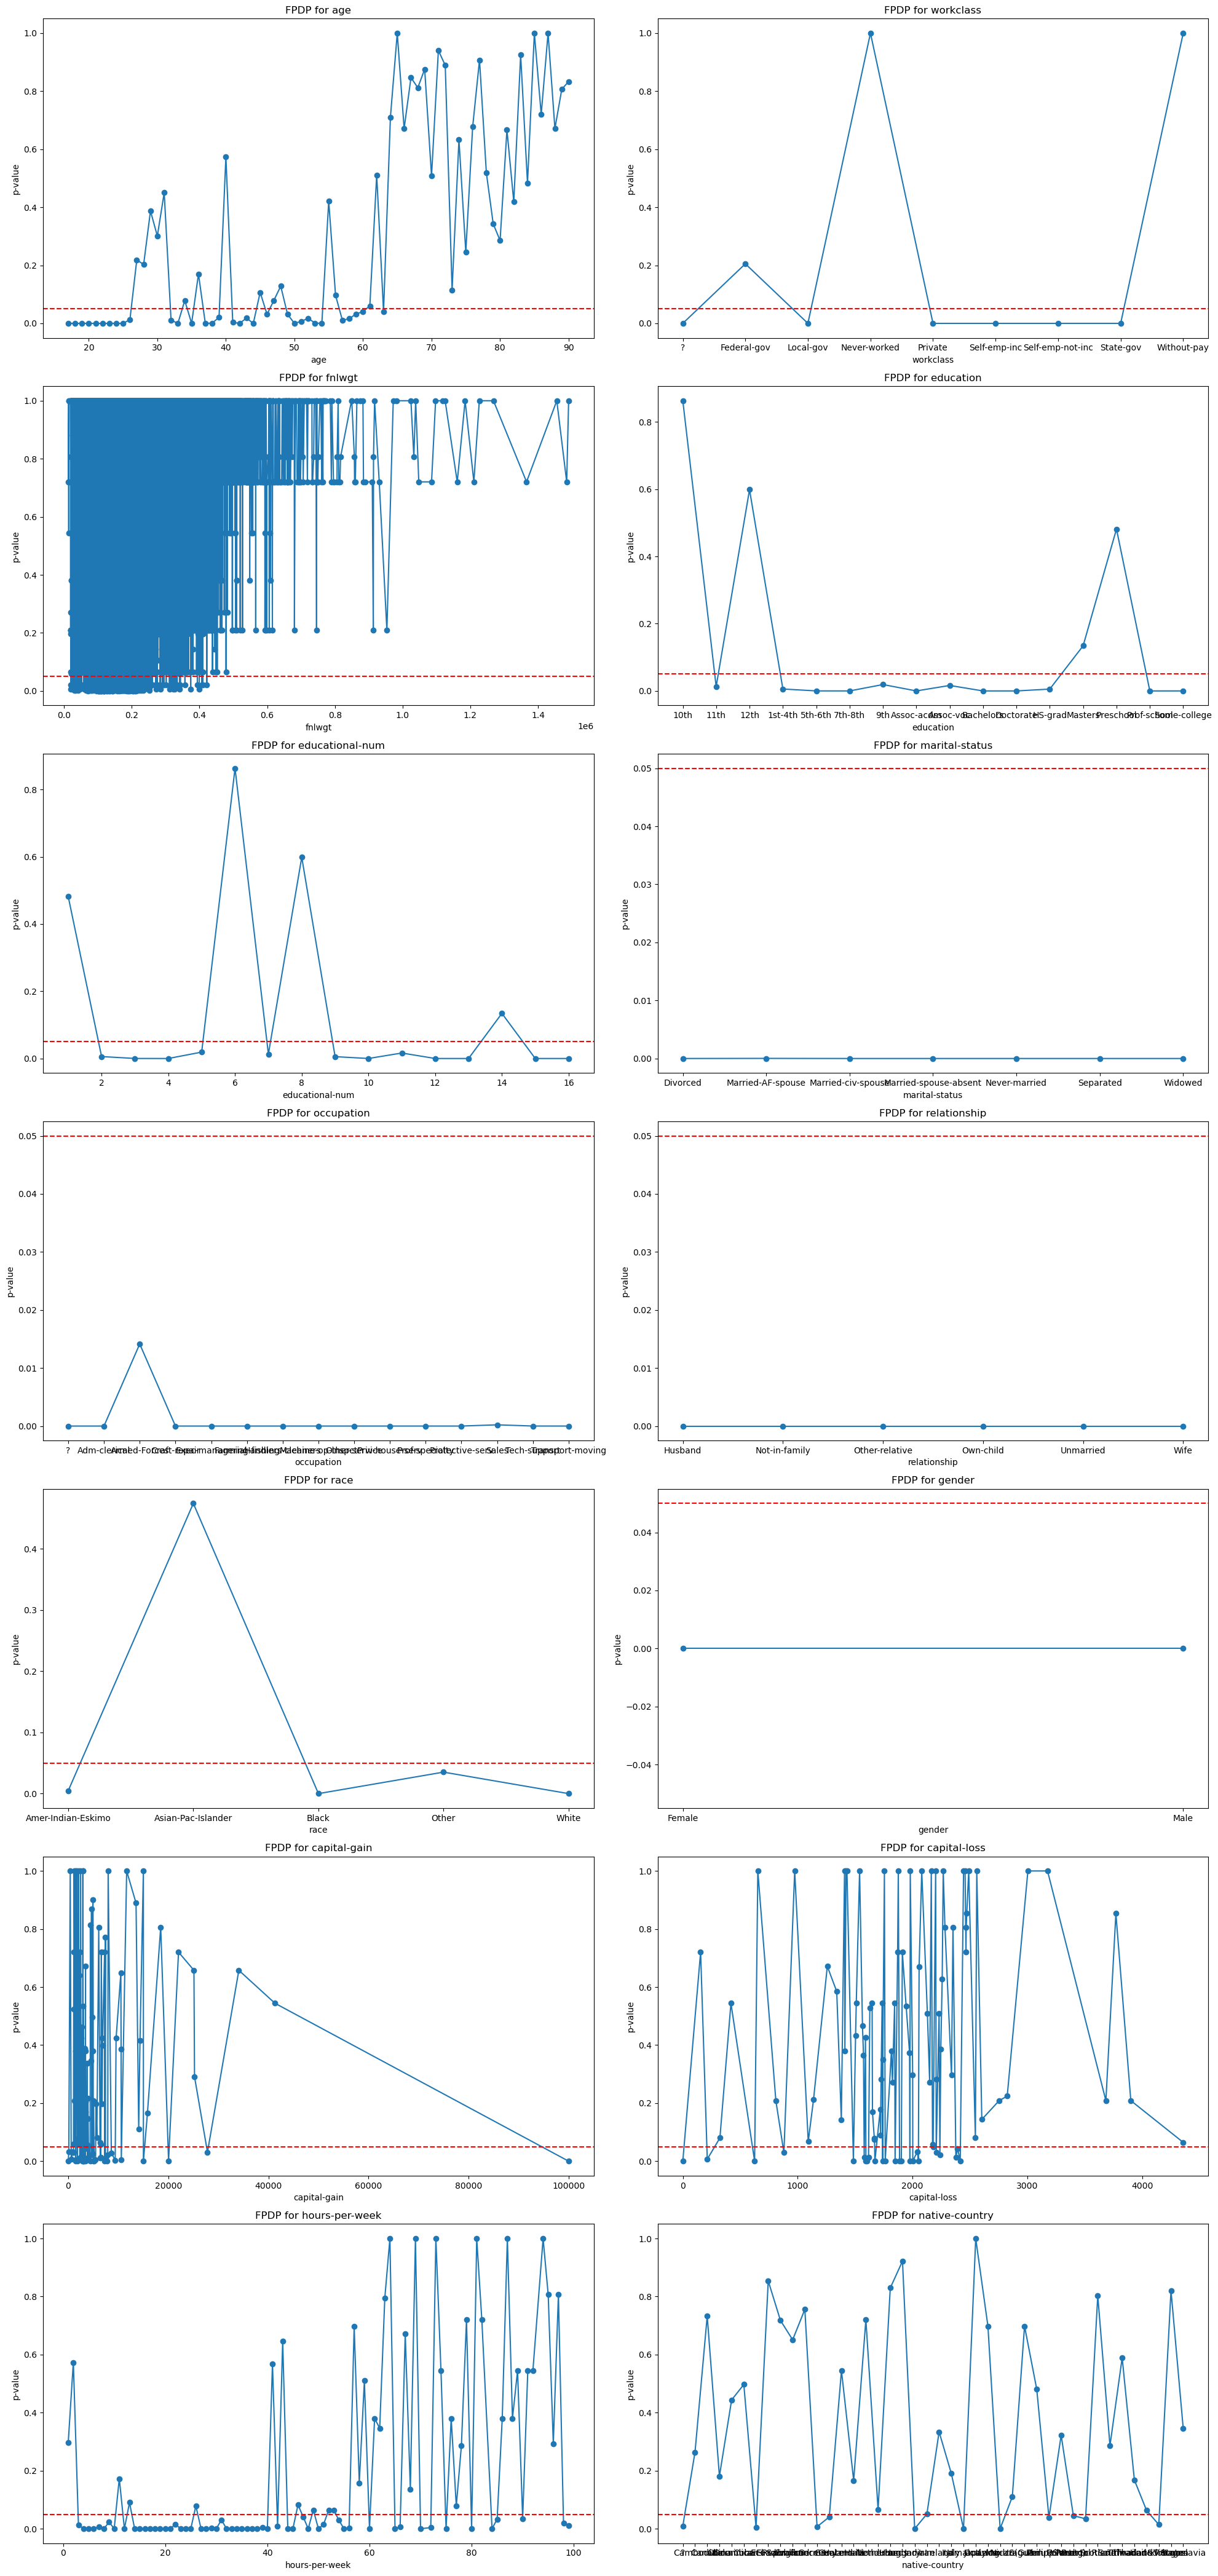

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# List of features for which you want to create the FPDP
features_of_interest = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

# Initialize empty dictionaries to store feature values and fairness test statistics
feature_values = {}
fairness_p_vals = {}

# Iterate over each feature of interest
for feature_name in features_of_interest:
    # Get unique values for the current feature
    unique_values = np.sort(data_df[feature_name].unique())
    
    # Initialize lists to store feature values and corresponding fairness test statistics
    values = []
    p_vals = []
    
    # Iterate over each unique feature value
    for value in unique_values:
        # Create a contingency table for the current feature value and Gender
        contingency_table = pd.crosstab(data_df['gender'], data_df[feature_name] == value)
        
        # Perform chi-squared test for statistical parity
        chi2, p, _, _ = chi2_contingency(contingency_table)
        
        # Append feature value and fairness test statistic to the lists
        values.append(value)
        #test_stats.append(chi2)
        p_vals.append(p)

    
    # Store feature values and test statistics in dictionaries
    feature_values[feature_name] = values
    fairness_p_vals[feature_name] = p_vals

# Assuming features_of_interest, feature_values, and fairness_p_vals are defined

# Calculate the number of rows needed
n_features = len(features_of_interest)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division to ensure enough rows

# Create subplots grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 6 * n_rows))
axs = axs.flatten()  # Flatten the 2D array of axes to simplify indexing

# Plot the FPDP for each feature
for i, feature_name in enumerate(features_of_interest):
    ax = axs[i]
    ax.plot(feature_values[feature_name], fairness_p_vals[feature_name], marker='o', linestyle='-')
    # Add a red line at p-value = 0.05 to the plot
    ax.axhline(y=0.05, color='red', linestyle='--', label='P-Value (0.05)')
    ax.set_xlabel(feature_name)
    ax.set_ylabel('p-value')
    ax.set_title(f'FPDP for {feature_name}')

# Hide any unused subplots
for i in range(n_features, n_rows * n_cols):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

plt.savefig('')